<div class="alert alert-info">

<H1> Data Analysis Challenge </H1>
Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.
</div>

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier, cv, plot_importance
import xgboost as xgb

# from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<div class="alert alert-info">

<H2> Part 1 ‐ Exploratory data analysis </H2>


<h3> Objectives </h3>
The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.
</div>

# Load and Explore Data

In [2]:
# Load data
login_data = pd.read_json('logins.json')
print(f"\nlogin_data.shape: {login_data.shape}\n")

# Add a column to represent the number of logins during each time
login_data['login_count'] = 1

# Convert the 'login_time' to datetime object, and set it as the index
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))[['login_count']]

# Check the data
login_data.head()


login_data.shape: (93142, 1)



,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


# Data Wrangling

**<font color='blue'> Process the time-series data of login counts based on 15 minute time intervals.</font>**

In [3]:
# Resample the index accordingly
logins_delta15 = login_data.resample('15Min').sum()
logins_delta15

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


**<font color='blue'> Visualize the processed data.</font>**

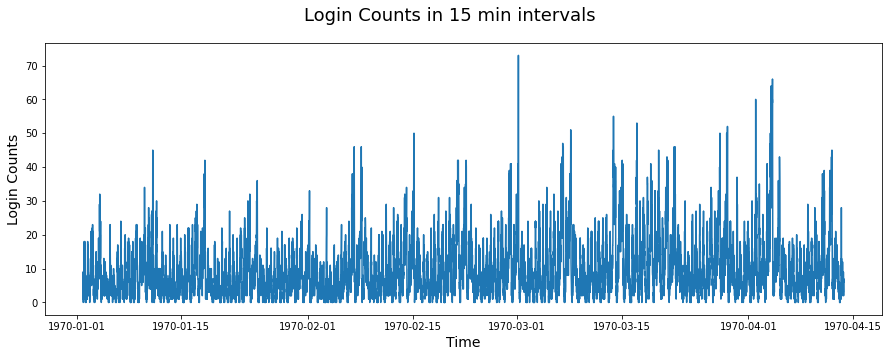

In [4]:
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Login Counts', fontsize = 14)

plt.suptitle('Login Counts in 15 min intervals', fontsize = 18)

plt.plot(logins_delta15.index, logins_delta15.login_count)

plt.show()

<div class="alert alert-warning">
<strong>It seems that there is an underlying pattern in the data. Let's explore it further since it's not very clear at this scale.
</strong>
</div>

<div class="alert alert-success">
<h3> To find important features of the demand, such as daily cycles, consider the following: </h3>
    <ol>
        <li>Look at the entire time-series with larger chunksize</li>
        <li>Look at specific days separately</li>
        <li>Find the busiest time of day</li>
    </ol>
</div>

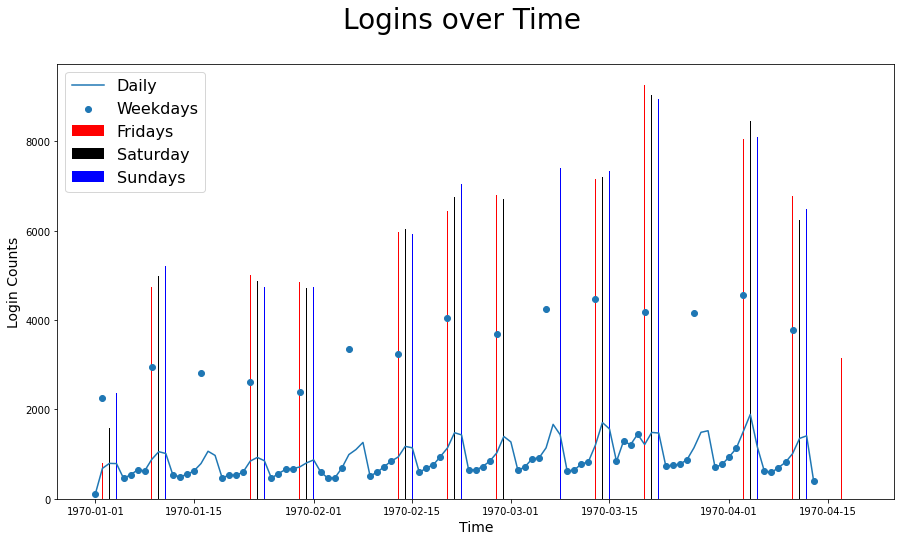

In [5]:
# Resample the index by days
logins_daily = login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()


# Line plot, scatterplot, and histograms of the resampled data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Login Counts', fontsize = 14)
plt.suptitle('Logins over Time', fontsize = 28)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'r')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'b')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)

plt.show()


**It is now clear that Fridays (red), in general, has the most logins, and that the weekends (black and blues vertical lines) are busier than the weekdays (light blue dots).**

<div class="alert alert-success">
<H3> Hourly trends by day of week</H3>
</div>

In [6]:
# Resample index hourly
daily_logins = login_data.resample('H').sum()

# Create a new column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week

# Add column with just the hour but omit the date
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [7]:
# Create a dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

# Stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])

# Name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

In [8]:
avg_hourly_logins_df

,hour,day_of_week,avg_num_logins
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000
...,...,...,...
163,23,Wednesday,64.857143
164,23,Thursday,68.866667
165,23,Friday,86.533333
166,23,Saturday,67.066667


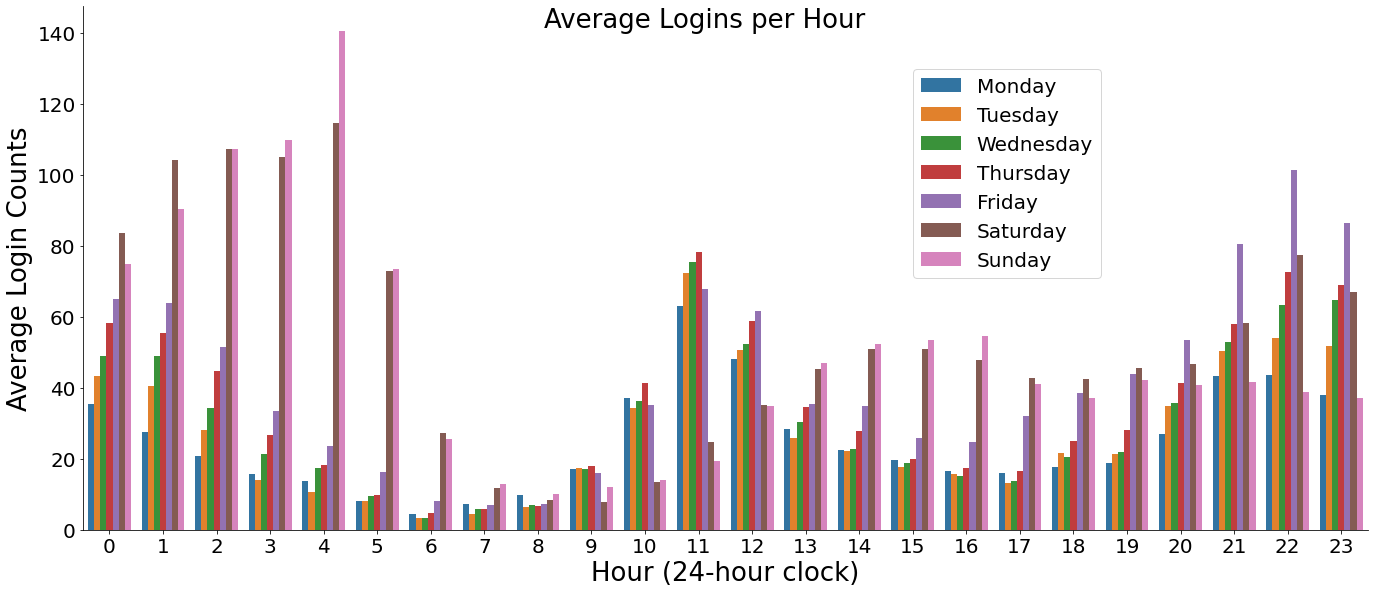

In [9]:
# Plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)

ax = plt.gca()
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Login Counts', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)

plt.suptitle('Average Logins per Hour', fontsize = 26)
plt.show()

**The abobe plot shows the heaviest usage occurs during the early hours (1 AM - 5 AM) on Saturday and Sunday. During the weekdays, there are smaller spikes in usage during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM).**

<div class="alert alert-info">
<H2> Part 2 ‑ Experiment and metrics design </H2>

<p>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
</p>

<p>
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
    <ol>
        <li> What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</li>
        <li> Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
            <ol>
                <li> how you will implement the experiment</li>
                <li> what statistical test(s) you will conduct to verify the significance of the observation</li>
                <li> how you would interpret the results and provide recommendations to the city operations team along with any caveats.</li> 
</ol>
    </ol>

<i>Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.</i>

</div>

*Let us make the following assumptions:*
1. We have a digital record of the number of cars that cross the bridge so that the partner drivers can enter how many times they are crossing the bridge and be reimbursed accordingly.
2. We have a time history data of the use of the bridge.

The key metric that can be used here is the change in weekday activity. In particular, we can explore if there is an increase of cars entering the bridge *from* Gotham during the daytime hours on weekdays (i.e., leaving Gotham since Gotham is most active at night), AND if there is an increase of cars entering the bridge *from* Metropolis during the night (i.e., leaving Metropolis since Metropolis is active during the day).

In order to answer the above questions we could do the follwing two hypothesis tests.
1. H0: There is no difference between the mean number of cars entering the bridge *from* Gotham during weekdays between 5 am and 10 am over 2 weeks before the reimbursement offer was announced and the mean number of cars over 2 weeks after the reimbursement offer was announced.

   HA: There is an **increase** in the mean number of cars entering the bridge from Gotham during weekdays between 5 am and 10 am for 2 weeks before the reimbursement offer was announced and the mean number of cars over 2 weeks after the reimbursement offer was announced.

2. H0: There is no difference between the mean number of cars entering the bridge *from* Metropolis during weekdays between 6 pm and 10 pm over 2 weeks before reimbursement offer was announced and the mean number of cars over 2 weeks after the reimbursement offer was announced.

   HA: There is an **increase** in the mean number of cars entering the bridge from Metropolis during weekdays between 6 pm and 10 pm over 2 weeks before reimbursement offer was announced and the mean number of cars over 2 weeks after the reimbursement offer was announced.
   
We can then conduct a one-tailed (because we looking for only **increase**) *z*-test to determine the *p*-value of each hypothesis. 

If the *p*-value turns out to be less than 0.05 for **both** tests, then the null hypotheses can be rejected. This would imply data supports the alternative hypothesis that there is an increase in use of the bridge. In this case, reimbursement program should be continued. Of course, we can conduct the tests again later after few months or a year after collecting more data.

On the other hand, if the *p*-value is more than 0.05 for **both** tests, then we would fail to reject the null hypotheses that there is no difference. In this case, a different program should be planned to encourage driver partners to be available in both cities.

If only one of the *p*-values is less than 0.05, then we would infer that the hypothesis tests above are inconclusive. In this case, further investigation would be required.

<div class="alert alert-info">

<H2> Part 3 ‑ Predictive modeling </H2>

<p>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
</p>

<p>
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
</p>

The data is in the attached file ultimate_data_challenge.json.
    <ol>
        <li> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
        <li> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>
        <li> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).</li>
                
   </ol>
</div>

### Data description

+ `city`: city this user signed up in
+ `phone`: primary device for this user
+ `signup_date`: date of account registration; in the form 'YYYYMMDD'
+ `last_trip_date`: the last time this user completed a trip; in the form 'YYYYMMDD'
+ `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup
+ `avg_rating_by_driver`: the rider’s average rating over all of their trips
+ `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips
+ `surge_pct`: the percent of trips taken with surge multiplier > 1
+ `avg_surge`: The average surge multiplier over all of this user’s trips
+ `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up
+ `ultimate_black_user`: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
+ `weekday_pct`: the percent of the user’s trips occurring during a weekday

<div class="alert alert-info">

<H3> Assumptions </H3>

The date of when the data was pulled is not given, so I cannot tell if they had a trip in the 30 days before that date, nor is a user ID given.

So, we make the following assumptions:
    <ol>
        <li>That the most recent trip taken was the day the data was pulled</li>
        <li>Each row represents a summary of a unique user </li>
    </ol>

</div>

# Data Wrangling and Exploratory Data Analysis

In [10]:
# Load data
user_data = pd.read_json('ultimate_data_challenge.json')
print(f"\nuser_data.shape: {user_data.shape}\n")
print(f"\nuser_data.isnull().sum():\n\n{user_data.isnull().sum()}\n")


user_data.shape: (50000, 12)


user_data.isnull().sum():

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64



### Handling missing values

In [11]:
user_data['phone'].fillna('no_phone', inplace = True)
user_data['avg_rating_by_driver'].fillna(user_data['avg_rating_by_driver'].median(), inplace = True)
user_data['avg_rating_of_driver'].fillna(user_data['avg_rating_of_driver'].median(), inplace = True)

In [12]:
user_data.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

### Cleaning and transforming data

In [13]:
# Convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# Date when the data was pulled
pull_date = user_data.last_trip_date.max()

# Determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# Assign active status by adding a column: 0 = inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# Add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [14]:
print(f"\nuser_data.shape: {user_data.shape}\n")
user_data.head()


user_data.shape: (50000, 17)



,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_no_phone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [15]:
# Split the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

**<font color='blue'>Q1. What fraction of the observed users were retained?</font>**

In [16]:
# Fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print(f"{fraction} percent of users were retained.")

36.62 percent of users were retained.


In [17]:
# Estimate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [18]:
stats_dict

{'avg_dist': [5.11897706171491,
  4.627946077352289,
  6.1884777532344595,
  6.213026890239864],
 'avg_rating_by_driver': [4.763560895685418,
  0.32442471716150173,
  4.7879993688860845,
  0.5027761034044329],
 'avg_rating_of_driver': [4.619623156744949,
  0.5217106038966701,
  4.6676112338277065,
  0.6038626277756979],
 'avg_surge': [1.0737203713817587,
  0.16318307628386217,
  1.0753666771852317,
  0.2502193167960326],
 'surge_pct': [9.128164937192789,
  15.489344384656372,
  8.688548437993058,
  22.13221116097671],
 'ultimate_black_user': [0.5111414527580557,
  0.4998895035280006,
  0.29962133165036287,
  0.45809934663927254],
 'weekday_pct': [62.21460404150738,
  29.06831885791796,
  60.18159671820763,
  40.98569793983108],
 'city_Astapor': [0.21966138722009831,
  0.4140285307334919,
  0.39482486588829285,
  0.48882075576165307],
 "city_King's Landing": [0.3444565811032223,
  0.4752037225354171,
  0.12063742505522247,
  0.3257105837895024],
 'city_Winterfell': [0.43588203167667944,

In [19]:
# Create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

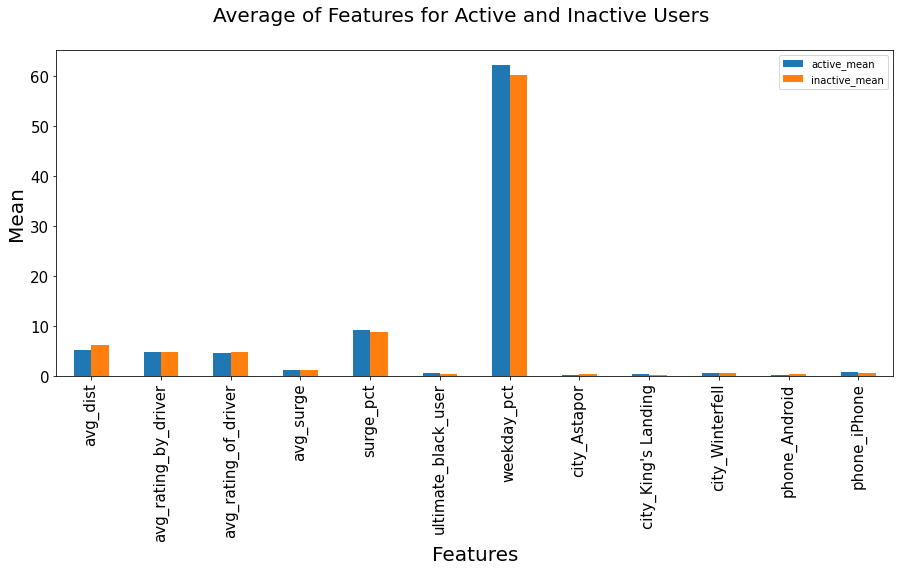

In [20]:
# Plot the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.suptitle('Average of Features for Active and Inactive Users', fontsize = 20)
plt.show()

**The bar graph of the statistcs shows that there is not distinct difference between the average of the features for active and inactive users.  Additionally, the `weekday_pct` feature has larger values than the others, suggessting that the data is not normalized.**

### Colored scatter_matrix

In [21]:
user_data['active_status']

0        1
1        0
2        0
3        1
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: active_status, Length: 50000, dtype: int64

In [22]:
colors = ['red' if ix else 'blue' for ix in user_data['active_status']]

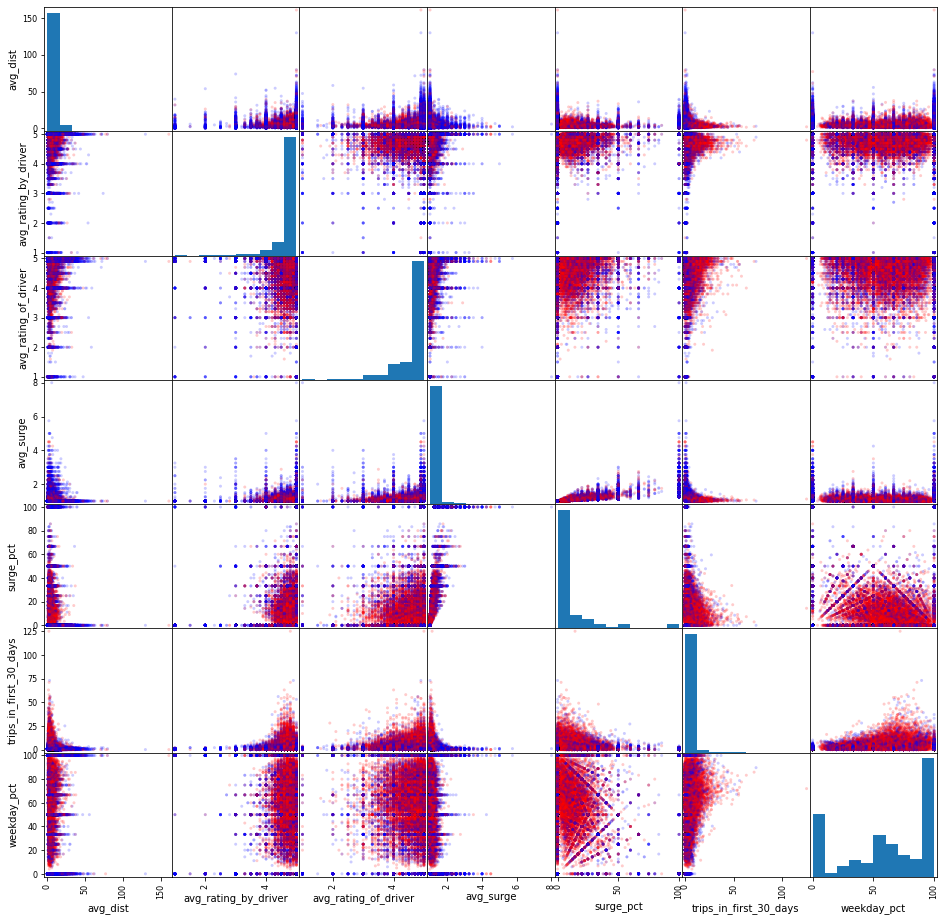

In [23]:
pd.plotting.scatter_matrix(user_data[[u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', 
                  u'avg_surge', u'surge_pct', u'trips_in_first_30_days', u'weekday_pct']],
              alpha=0.2, figsize=(16, 16), diagonal='hist', c=colors)
plt.show()

# Data Preprocessing and Modeling

**<font color='blue'>Q2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</font>**

<div class="alert alert-info">
<p>
This is a binary classification problem with both numerical and categorical data consisting of 50,000 records. We will implement <b>XGBoost</b> since it is appropriate for the large amount of data with less number of features. It is also fast and memory efficient. Other models that could be considered for this data are random forest, logistic regression, and LightGBM. However, random forest may be biased towards categorical varriables. Logistic regression may suffer when the feature variables show multi-colinearity. LightGBM can actually be better than XGBoost computationally, but performance wise both XGBoost and LightGBM are similar.
</p>
</H3>
</div>

In [24]:
# Define features and target
X = user_data[feature_columns]
y = user_data.active_status

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123, stratify = y)

### XGBoost Classifier

In [25]:
parameters = {'objective':'binary:logistic',
              'n_estimators': 50,
              'random_state': 42,
              'silent': 1,
              'max_depth': 8
             }

In [26]:
# Suppress warning from XGBoost
# Ref: https://stackoverflow.com/questions/66293635/warning-about-parameters-in-xgboost-function-in-python
xgb.set_config(verbosity=0)

In [27]:
# Instantiate classifier
xg_clf = xgb.XGBClassifier(**parameters)
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [28]:
# Predict tarinin set
y_train_pred = xg_clf.predict(X_train)

# Score
score = accuracy_score(y_train, y_train_pred)

# Print accuracy
print(f"\naccuracy_score(y_train, y_train_pred): {score}\n")


accuracy_score(y_train, y_train_pred): 0.8476857142857143



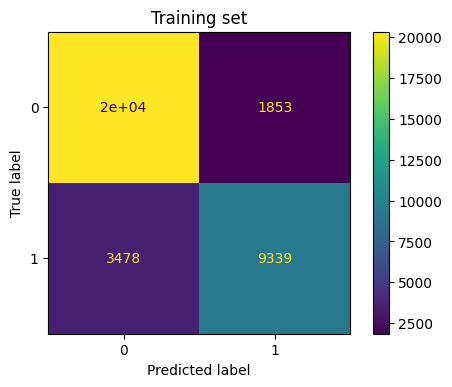

In [29]:
plt.figure(dpi = 100)
ax = plt.subplot(111)
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
plt.title(f"Training set")
plt.show()

In [30]:
# Predict tarinin set
y_test_pred = xg_clf.predict(X_test)

# Score
score = accuracy_score(y_test, y_test_pred)

# Print accuracy
print(f"\naccuracy_score(y_test, y_test_pred): {score}\n")


accuracy_score(y_test, y_test_pred): 0.7820666666666667



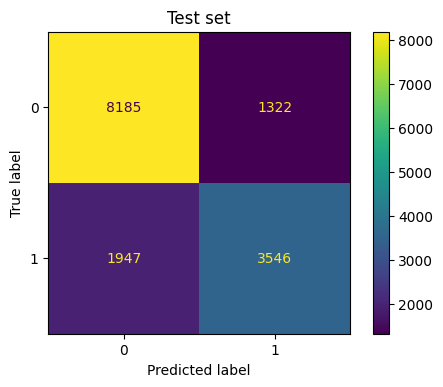

In [31]:
plt.figure(dpi = 100)
ax = plt.subplot(111)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax = ax)
plt.title(f"Test set")
plt.show()

This model is not great. It seems to be overfitting. But, it's not very poor either. We will move ahead with it.

### Hyperparameter optimization

We can also use `GridSearchCV` to determine the best hyperparameters. But, we will skip this step here since accuracy of the model on the test data is reasonable.

In [32]:
# Dictionary of parameters to optimize, and the range of optimization values

# parameters = {
#     'max_delta_step':[0,0.05],
#     'scale_pos_weight':[0.95, 0.9],
#     'subsample':[1,0.8],
#     'learning_rate': [0.25, 0.2, 0.1],
#     'min_child_weight':[0,1,2],
#     'gamma':[1, 2, 3]
#     }

In [33]:
# Instantiate XGBoost classifier

# xg_clf = xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# # GridSearch
# grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
# grid_search.fit(X_train,y_train)

In [34]:
# Print best parameters and results

# print(grid_search.best_params_)
# print(grid_search.best_score_)

### Model Insight and Feature importance

**<font color='blue'>Q3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).</font>**

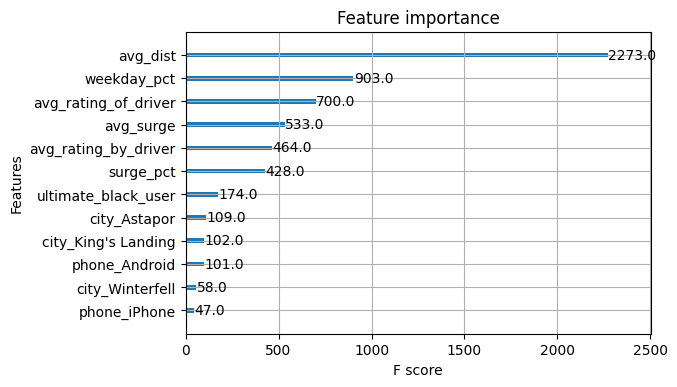

In [35]:
fig, ax = plt.subplots(dpi = 100)
xgb.plot_importance(xg_clf, ax = ax)
plt.show()

**Conclusions**: The top feature that most heavily influences rider retention is `avg_dist` that represents the average distance in miles per trip taken in the first 30 days after signup. The next 2 important features are `weekday_pct` and `avg_rating_of_driver`.

**Note**: The XGBoost model that we used above is, however, overfitting. So, the above observation should be taken with a grain of salt. A better model by optimizing the hyperparameters using, say, `GridSearchCV`, may be considered as a next step, or another model, such as, LightGBM or SVM can also be considered.